In [1]:
from typing import Callable, Dict, Iterable, Self
from numpy.typing import NDArray
from itertools import product
from functools import partial
import datasets
import numpy as np
import einops
import pandas as pd
import pickle
import sklearn.metrics as skm
import sklearn.preprocessing as skp
import matplotlib.pyplot as plt
import json
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

import flagon
import flax_lightning

# Solar Home Dataset

In [2]:
def get_data():
    with open("data/solar_home_data.pkl", 'rb') as f:
        data = pickle.load(f)
    X_train, Y_train = [], []
    X_test, Y_test = [], []
    for customer_data in data.values():
        idx = np.arange(24, len(customer_data))
        expanded_idx = np.array([np.arange(i - 24, i - 1) for i in idx])
        X_train.append(customer_data[expanded_idx][:300 * 24])
        Y_train.append(customer_data[idx, 0][:300 * 24])
        X_test.append(customer_data[expanded_idx][300 * 24:])
        Y_test.append(customer_data[idx, 0][300 * 24:])
    return np.concatenate(X_train), np.concatenate(Y_train), np.concatenate(X_test), np.concatenate(Y_test)

X_train, Y_train, X_test, Y_test = get_data()

In [3]:
processor = skp.MinMaxScaler().fit(Y_train.reshape(-1, 1))
Y_train = processor.transform(Y_train.reshape(-1, 1)).reshape(-1)
Y_test = processor.transform(Y_test.reshape(-1, 1)).reshape(-1)

# Try
processor = skp.StandardScaler().fit(X_train.reshape(-1, 23 * 4))
X_train = processor.transform(X_train.reshape(-1, 23 * 4)).reshape(-1, 23, 4)
X_test = processor.transform(X_test.reshape(-1, 23 * 4)).reshape(-1, 23, 4)

In [4]:
class Net(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(32, (3,))(x)
        x = nn.relu(x)
        x = nn.Conv(32, (3,))(x)
        x = nn.relu(x)
        x = nn.Conv(64, (3,))(x)
        x = nn.relu(x)

        x = einops.rearrange(x, "b t s -> b (t s)")
        x = nn.Dense(100)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return nn.sigmoid(x)


def create_model(lr=0.0005, opt=optax.adam, loss="log_cosh_loss", seed=None):
    model = Net()
    params = model.init(jax.random.PRNGKey(seed if seed else 42), jnp.zeros((1, 23, 4)))
    return flax_lightning.Model(
        model,
        params,
        opt(lr),
        loss,
        metrics=["mean_absolute_error", "r2score"],
        seed=seed
    )

In [5]:
model = create_model(0.1, partial(optax.sgd, momentum=0.9), "l2_loss")
model.step(X_train, Y_train, 3, verbose=1)
model.evaluate(X_test, Y_test)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
100%|██████████| 67500/67500 [01:36<00:00, 699.63it/s, LOSS: 0.000, epoch: 3/3]


{'mean_absolute_error': Array(0.02007486, dtype=float32),
 'r2score': Array(0.3107775, dtype=float32)}

In [11]:
optimizers = {"sgd": optax.sgd, "momentum": partial(optax.sgd, momentum=0.9), "adam": optax.adam}
df = pd.DataFrame()

for lr, opt_name, loss in product((0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001), optimizers.keys(), ("mean_absolute_error", "l2_loss", "log_cosh_loss")):
    print(f"{lr=}, {opt_name=}, {loss=}")
    opt = optimizers[opt_name]
    model = create_model(lr=lr, opt=opt, loss=loss)
    model.step(X_train, Y_train, 1, verbose=1)
    results = model.evaluate(X_test, Y_test, verbose=0)
    df = pd.concat((df, pd.DataFrame({"lr": [lr], "optimizer": [opt_name], "loss": [loss], "r2 score": [results['r2score'].item()]})))

lr=0.1, opt_name='sgd', loss='mean_absolute_error'


100%|██████████| 67500/67500 [01:20<00:00, 835.00it/s, LOSS: 0.410, epoch: 1/1]


lr=0.1, opt_name='sgd', loss='l2_loss'


100%|██████████| 67500/67500 [01:19<00:00, 845.83it/s, LOSS: 0.182, epoch: 1/1]


lr=0.1, opt_name='sgd', loss='log_cosh_loss'


100%|██████████| 67500/67500 [01:21<00:00, 826.74it/s, LOSS: 0.141, epoch: 1/1]


lr=0.1, opt_name='momentum', loss='mean_absolute_error'


100%|██████████| 67500/67500 [01:23<00:00, 806.68it/s, LOSS: 0.444, epoch: 1/1]


lr=0.1, opt_name='momentum', loss='l2_loss'


100%|██████████| 67500/67500 [01:23<00:00, 810.71it/s, LOSS: 0.186, epoch: 1/1]


lr=0.1, opt_name='momentum', loss='log_cosh_loss'


100%|██████████| 67500/67500 [01:23<00:00, 812.20it/s, LOSS: 0.289, epoch: 1/1]


lr=0.1, opt_name='adam', loss='mean_absolute_error'


100%|██████████| 67500/67500 [01:27<00:00, 767.08it/s, LOSS: 0.266, epoch: 1/1]


lr=0.1, opt_name='adam', loss='l2_loss'


100%|██████████| 67500/67500 [01:27<00:00, 768.28it/s, LOSS: 0.126, epoch: 1/1]


lr=0.1, opt_name='adam', loss='log_cosh_loss'


100%|██████████| 67500/67500 [01:27<00:00, 774.84it/s, LOSS: 0.040, epoch: 1/1]


lr=0.05, opt_name='sgd', loss='mean_absolute_error'


100%|██████████| 67500/67500 [01:19<00:00, 849.53it/s, LOSS: 0.546, epoch: 1/1]


lr=0.05, opt_name='sgd', loss='l2_loss'


100%|██████████| 67500/67500 [01:19<00:00, 847.20it/s, LOSS: 0.136, epoch: 1/1]


lr=0.05, opt_name='sgd', loss='log_cosh_loss'


100%|██████████| 67500/67500 [01:19<00:00, 844.28it/s, LOSS: 0.148, epoch: 1/1]


lr=0.05, opt_name='momentum', loss='mean_absolute_error'


100%|██████████| 67500/67500 [01:23<00:00, 812.93it/s, LOSS: 0.424, epoch: 1/1]


lr=0.05, opt_name='momentum', loss='l2_loss'


100%|██████████| 67500/67500 [01:22<00:00, 822.44it/s, LOSS: 0.096, epoch: 1/1]


lr=0.05, opt_name='momentum', loss='log_cosh_loss'


100%|██████████| 67500/67500 [01:22<00:00, 820.50it/s, LOSS: 0.084, epoch: 1/1]


lr=0.05, opt_name='adam', loss='mean_absolute_error'


100%|██████████| 67500/67500 [01:27<00:00, 769.41it/s, LOSS: 0.610, epoch: 1/1]


lr=0.05, opt_name='adam', loss='l2_loss'


100%|██████████| 67500/67500 [01:26<00:00, 777.12it/s, LOSS: 0.062, epoch: 1/1]


lr=0.05, opt_name='adam', loss='log_cosh_loss'


100%|██████████| 67500/67500 [01:27<00:00, 774.83it/s, LOSS: 0.167, epoch: 1/1]


lr=0.01, opt_name='sgd', loss='mean_absolute_error'


100%|██████████| 67500/67500 [01:20<00:00, 843.55it/s, LOSS: 0.391, epoch: 1/1]


lr=0.01, opt_name='sgd', loss='l2_loss'


100%|██████████| 67500/67500 [01:19<00:00, 845.64it/s, LOSS: 0.302, epoch: 1/1]


lr=0.01, opt_name='sgd', loss='log_cosh_loss'


100%|██████████| 67500/67500 [01:20<00:00, 843.05it/s, LOSS: 0.132, epoch: 1/1]


lr=0.01, opt_name='momentum', loss='mean_absolute_error'


100%|██████████| 67500/67500 [01:22<00:00, 818.73it/s, LOSS: 0.445, epoch: 1/1]


In [9]:
df

,lr,optimizer,loss,r2 score
0,0.1000,sgd,mean_absolute_error,-0.760915
0,0.1000,sgd,l2_loss,-0.760827
0,0.1000,sgd,log_cosh_loss,-0.760912
0,0.1000,momentum,mean_absolute_error,-0.760688
0,0.1000,momentum,l2_loss,-0.760034
...,...,...,...,...
0,0.0001,momentum,l2_loss,-0.760098
0,0.0001,momentum,log_cosh_loss,-0.760676
0,0.0001,adam,mean_absolute_error,-0.666119
0,0.0001,adam,l2_loss,-0.608143


# Electricity Consumption Dataset

In [50]:
with open("data/electricity_consumption_2020-2021.pkl", 'rb') as f:
    electricity_con_data = pickle.load(f)

with open("data/central_coast_hunter_weather.pkl", 'rb') as f:
    weather_data = pickle.load(f)

In [51]:
def get_customer_data(lga=0, customer=0):
    idx = np.arange(30, len(electricity_con_data[lga][customer]))
    expanded_idx = np.array([np.arange(i - 30, i - 1) for i in idx])
    return np.concatenate((electricity_con_data[lga][customer, expanded_idx].reshape(-1, 29, 1), weather_data[str(lga)][expanded_idx]), axis=-1), electricity_con_data[lga][customer, idx]

In [52]:
def create_model() -> tf.keras.Model:
    inputs = tf.keras.Input((29, 8))
    # x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Conv1D(64, 5, activation="relu")(inputs)
    x = tf.keras.layers.Conv1D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Conv1D(32, 2, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(100, activation="relu")(x)
    x = tf.keras.layers.Dense(50, activation="relu")(x)
    x = tf.keras.layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss="mean_squared_error",
        metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

In [60]:
def create_clients(create_model_fn, nclients, seed=None):
    def create_client(client_id: str):
        lga = int(client_id[:client_id.find('-')])
        customer = int(client_id[client_id.find('-') + 1:])
        client_X, client_Y = get_customer_data(lga, customer)
        client_data = {"train": {"X": client_X[:300], "Y": client_Y[:300]}, "test": {"X": client_X[300:], "Y": client_Y[300:]}}
        return Client(client_data, create_model_fn)
    return create_client

In [55]:
class Client(flagon.Client):
    def __init__(self, data, create_model_fn):
        self.data = data
        self.model = create_model_fn()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        history = self.model.fit(self.data['train']['X'], self.data['train']['Y'], epochs=config['num_epochs'])
        return self.model.get_weights(), len(self.data['train']), {k: v[-1] for k, v in history.history.items()}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, mae, rmse = self.model.evaluate(self.data['test']['X'], self.data['test']['Y'])
        return len(self.data['test']), {'loss': loss, 'mean absolute error': mae, 'root mean squared error': rmse}

In [67]:
server = flagon.Server(create_model().get_weights(), {"num_rounds": 1, "num_episodes": 1, "num_epochs": 1})
network_arch = {
    "clients": [{"clients": lga_data.shape[0] // 1000} for lga_data in electricity_con_data.values()],
}
flagon.start_simulation(
    server,
    create_clients(create_model, flagon.common.count_clients(network_arch)),
    network_arch
)

KeyError: 96

11/11 [==============================] - 0s 672us/step


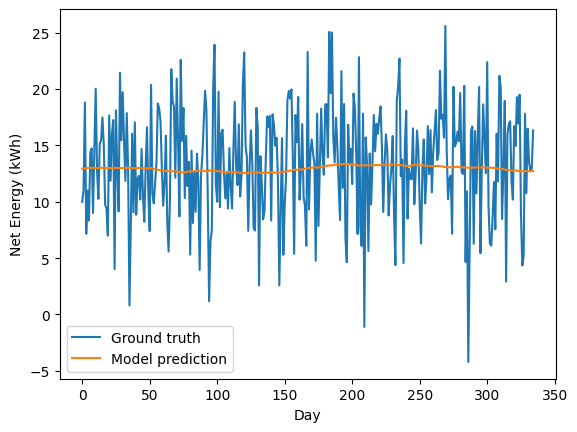

In [62]:
plt.plot(np.arange(len(Y)), Y, '-', label="Ground truth")

preds = model.predict(X)
plt.plot(np.arange(len(preds)), preds, '-', label="Model prediction")
plt.xlabel("Day")
plt.ylabel("Net Energy (kWh)")
plt.legend()
plt.show()